In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pydmps.dmp_discrete import DMPs_discrete
from pydmps.dmp_rhythmic import DMPs_rhythmic

In [6]:
# Loading the data

try:
    import re
    with open('data.txt', 'r') as f:
        text = f.read()
        text = text.replace('[', '').replace(']', '').replace('\n', '')
        trajectory_data = np.fromstring(text, sep=' ').reshape(-1, 7)
except:
    print("Trajectory not found")
    trajectory_data = np.zeros((400, 7))

In [9]:
# Segment the trajectory data to get reaching and stirring parts

split_idx = 140 

reach_data = trajectory_data[:split_idx, :]
stir_data = trajectory_data[split_idx:, :]

# IMPORTANT: The library expects shapes (n_dmps, n_timesteps)
# My data is (n_timesteps, n_dmps), so transpose
reach_data_T = reach_data.T
stir_data_T = stir_data.T

n_dims = 7
dt = 0.01  #Assuming 100Hz sampling rate

In [10]:
# Training
print("Training Discrete DMP (Reach)...")
# We use more BFs (e.g., 100) to ensure high accuracy of the reach path
dmp_discrete = DMPs_discrete(n_dmps=n_dims, n_bfs=100, dt=dt)

# The library interpolates internally, so we just feed the path
dmp_discrete.imitate_path(y_des=reach_data_T)

# 4. Train the Rhythmic DMP (Stirring)
# ---------------------------------------------------------
print("Training Rhythmic DMP (Stirring)...")
# Rhythmic DMPs model the periodic oscillation around a center
dmp_rhythmic = DMPs_rhythmic(n_dmps=n_dims, n_bfs=100, dt=dt)
dmp_rhythmic.imitate_path(y_des=stir_data_T)

Training Discrete DMP (Reach)...
Training Rhythmic DMP (Stirring)...


array([[ 0.2803675 ,  0.2809077 ,  0.28144791, ...,  0.32297747,
         0.323262  ,  0.32354653],
       [-0.14149958, -0.14138487, -0.14127017, ..., -0.13776487,
        -0.13777316, -0.13778145],
       [-0.1909369 , -0.19141205, -0.1918872 , ..., -0.21579085,
        -0.21583493, -0.21587901],
       ...,
       [-0.12834932, -0.12843153, -0.12851374, ..., -0.13338584,
        -0.13340766, -0.13342949],
       [ 0.27837556,  0.27836847,  0.27836139, ...,  0.27964482,
         0.279659  ,  0.27967319],
       [-0.91022469, -0.91040978, -0.91059486, ..., -0.90747189,
        -0.90727358, -0.90707526]])

In [16]:
# Regeneration

y_track_reach, dy_track_reach, ddy_track_reach = dmp_discrete.rollout()

# B. Transition Logic
# -------------------

last_pos_discrete = y_track_reach[-1]
dmp_rhythmic.y0 = last_pos_discrete
dmp_rhythmic.reset_state() # Apply new y0

# C. Rollout Rhythmic
# -------------------
stir_duration = 400 
y_track_stir, dy_track_stir, ddy_track_stir = dmp_rhythmic.rollout(timesteps=stir_duration)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


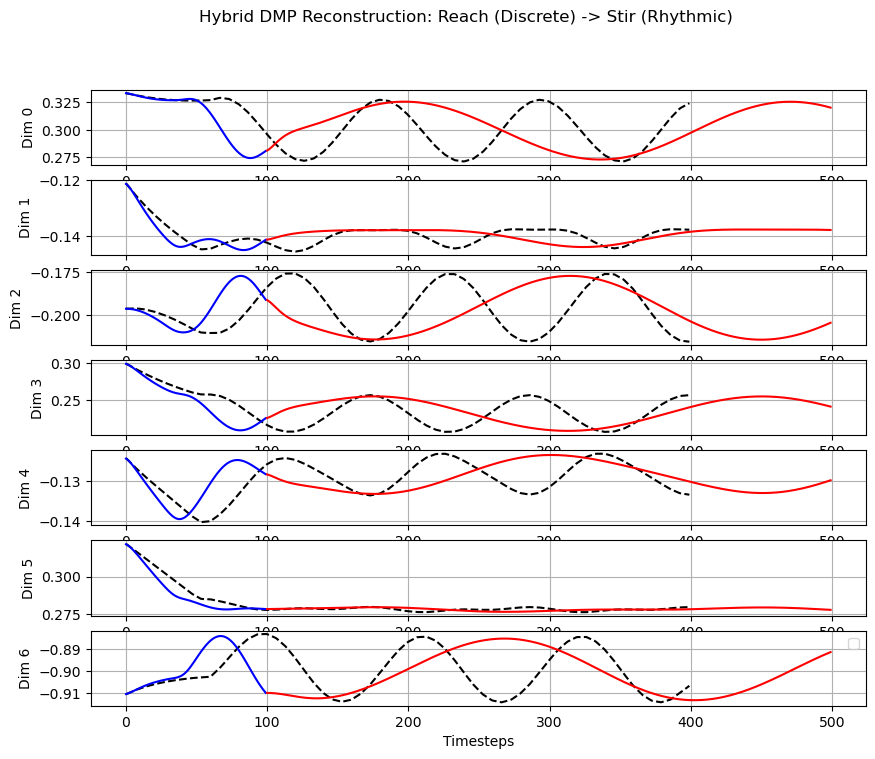

In [17]:
# Visualize Results
# ---------------------------------------------------------
full_reconstruction = np.vstack((y_track_reach, y_track_stir))
full_original = trajectory_data

plt.figure(figsize=(10, 8))

# Plot just the first 3 dimensions for clarity
dims_to_plot = [0, 1, 2, 3, 4, 5, 6] 

for i, dim in enumerate(dims_to_plot):
    plt.subplot(len(dims_to_plot), 1, i+1)
    
    # Plot Original Data
    plt.plot(full_original[:, dim], 'k--', label='Original Data' if i==0 else "")
    
    # Plot Generated Discrete Part
    plt.plot(y_track_reach[:, dim], 'b', label='Discrete DMP' if i==0 else "")
    
    # Plot Generated Rhythmic Part (shifted in time for visualization)
    time_offset = len(y_track_reach)
    time_axis_stir = np.arange(time_offset, time_offset + len(y_track_stir))
    plt.plot(time_axis_stir, y_track_stir[:, dim], 'r', label='Rhythmic DMP' if i==0 else "")
    
    plt.ylabel(f'Dim {dim}')
    plt.grid(True)

plt.xlabel('Timesteps')
plt.legend()
plt.suptitle('Hybrid DMP Reconstruction: Reach (Discrete) -> Stir (Rhythmic)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


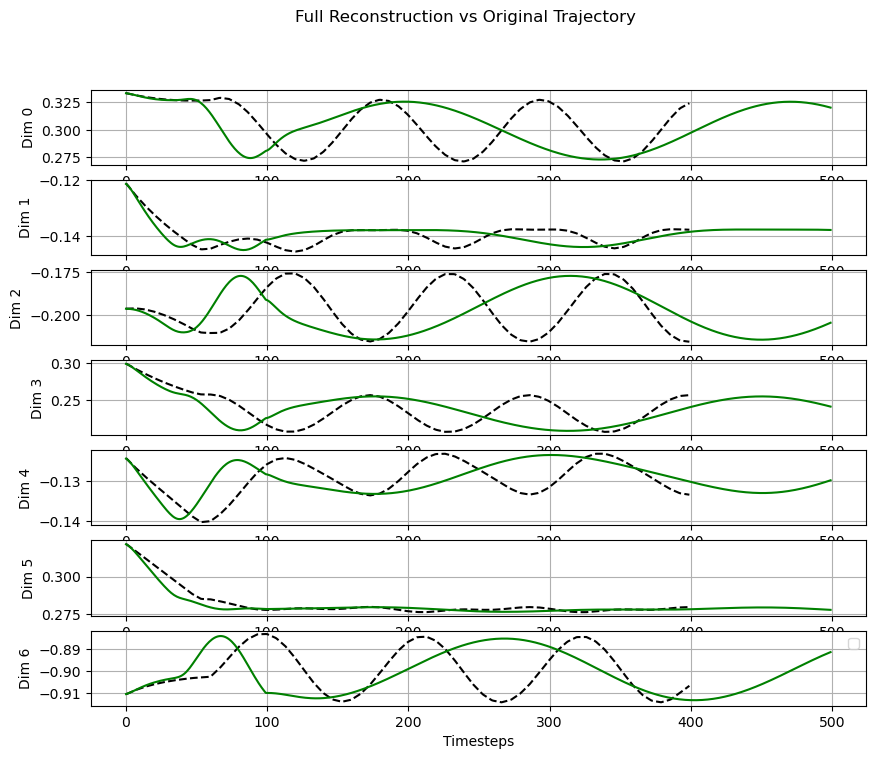

In [19]:
#plot full reconstruction vs original
plt.figure(figsize=(10, 8))
for i, dim in enumerate(dims_to_plot):
    plt.subplot(len(dims_to_plot), 1, i+1)
    plt.plot(full_original[:, dim], 'k--', label='Original Data' if i==0 else "")
    plt.plot(full_reconstruction[:, dim], 'g', label='Full Reconstruction' if i==0 else "")
    plt.ylabel(f'Dim {dim}')
    plt.grid(True)

plt.xlabel('Timesteps')
plt.legend()
plt.suptitle('Full Reconstruction vs Original Trajectory')
plt.show()